*Last edit by David Lao - 2017/11/14*
<br>
<br>

![](https://s.yimg.com/ny/api/res/1.2/sybAk0uKKJIlkVhfz5Jtuw--/YXBwaWQ9aGlnaGxhbmRlcjtzbT0xO3c9ODAw/http://media.zenfs.com/en-GB/homerun/uk.goal.com/42bf6d3fd31612f17e7b59c6260595db)


# FIFA Analytics - Predict Player Position through Machine Learning



After part 1 analysis on [finding the best squad](https://www.kaggle.com/laowingkin/fifa-18-find-the-best-squad), I will try to train the model and predict the player's preferred position based on different features. The dataset contains all FIFA 18 players **(~18K players)** with **70+** attributes.


## Contents

* Data manipulation
* Data normalization (and why it is needed)
* Predict binary targets (attack vs defend positions) with logistic regression
* Feature selections
* Study PCA impact on model accuracy
* Study LDA impact on model accuracy (*Edit on 2017/10/13*)
* Predict all positions (14 targets) with logistic regression (*Edit on 2017/10/06*)
* Predict all positions (14 targets) with random forest (*Edit on 2017/10/06*)
* Predict all positions (14 targets) with neural networks (*Edit on 2017/10/09*)

<br>
Appreciate if you can **Upvote** if this notebook is helpful to you in some ways!


## Data manipulation

First let's import some packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline 

Load the data:

In [2]:
df = pd.read_csv('CompleteDataset.csv')
df.head()

d:\ProgramFiles\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check out columns:

In [3]:
df.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID',
       'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB',
       'Preferred Positions', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

Gather only columns that we need for this analysis purpose:

In [4]:
# GK attributes are not our interest
columns_needed = ['Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'Preferred Positions']

# attack attribute first, then defence, then mixed
columns_needed_rearranged = ['Aggression','Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'Heading accuracy', 'Long shots','Penalties', 'Shot power', 'Volleys', 
       'Short passing', 'Long passing',
       'Interceptions', 'Marking', 'Sliding tackle', 'Standing tackle',
       'Strength', 'Vision', 'Acceleration', 'Agility', 
       'Reactions', 'Stamina', 'Balance', 'Ball control','Composure','Jumping', 
       'Sprint speed', 'Positioning','Preferred Positions']

df = df[columns_needed_rearranged]
df.head()

,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,...,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,...,89,96,92,63,93,95,95,91,95,ST LW
1,48,77,89,97,95,90,71,88,74,85,...,90,95,73,95,95,96,68,87,93,RW
2,56,75,81,96,89,84,62,77,81,80,...,96,88,78,82,95,92,61,90,90,LW
3,78,77,86,86,94,84,77,86,85,87,...,86,93,89,60,91,83,69,77,92,ST
4,29,15,14,30,13,11,25,16,47,25,...,52,85,44,35,48,70,78,61,12,GK


We don't want to classify GK because it will be too obvious:

In [5]:
df['Preferred Positions'] = df['Preferred Positions'].str.strip()
df = df[df['Preferred Positions'] != 'GK']
df.head()



,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,...,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,...,89,96,92,63,93,95,95,91,95,ST LW
1,48,77,89,97,95,90,71,88,74,85,...,90,95,73,95,95,96,68,87,93,RW
2,56,75,81,96,89,84,62,77,81,80,...,96,88,78,82,95,92,61,90,90,LW
3,78,77,86,86,94,84,77,86,85,87,...,86,93,89,60,91,83,69,77,92,ST
5,80,62,77,85,91,84,85,83,81,88,...,78,91,79,80,89,87,84,83,91,ST


Check any missing data:

In [6]:
df.isnull().values.any()

False

All possible outcome for preferred position:

In [7]:
p = df['Preferred Positions'].str.split().apply(lambda x: x[0]).unique()
p

array(['ST', 'RW', 'LW', 'CDM', 'CB', 'RM', 'CM', 'LM', 'LB', 'CAM', 'RB',
       'CF', 'RWB', 'LWB'], dtype=object)

Handle players with multiple preferred positions: duplicate a set of data for each

In [8]:
# copy a structure
df_new = df.copy()
df_new.drop(df_new.index, inplace=True)

for i in p:
    df_temp = df[df['Preferred Positions'].str.contains(i)]
    df_temp['Preferred Positions'] = i
    df_new = df_new.append(df_temp, ignore_index=True)
    
df_new.iloc[::500, :]
            



d:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,...,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,...,89,96,92,63,93,95,95,91,95,ST
500,69,44,55,66,80-3,54,65,75,75,82,...,68-2,67,86-3,64+4,68,63,69,75-3,70+3,ST
1000,70,62,59,67,68,43,71,63,67,66,...,68,68,74,70,69,67,72,63,75,ST
1500,46,55,41,69,67,41,59,62,61,64,...,67,68,47,71,71,64,73,67,64,ST
2000,32,59,47,67,53,42,40,42,51,50,...,81,58,66,79,65,44,60,84,61,ST
2500,64,62,48,66,61,31,55,52,49,65,...,70,45,74,66,60,48,68,69,58,ST
3000,42,31,36,48,61,27,59,49,53,53,...,58,53,55,56,52,49,78,56,49,ST
3500,66,65,66,75,66,55,59,69,53,79,...,73,68,79,62,74,65,75,91,68,RW
4000,41,59,38,61,57,36,58,52,57,59,...,70,65,72,69,58,49,54,77,60,RW
4500,76,73,57,72,42,59,60,41,35,57,...,82,65,71,83,72,64,70,79,57,LW


Some of the attributes have '+/-' sign, let's perform the calculation rather than keeping them as string:

In [9]:
cols = [col for col in df_new.columns if col not in ['Preferred Positions']]

for i in cols:
    df_new[i] = df_new[i].apply(lambda x: eval(x) if isinstance(x,str) else x)

df_new.iloc[::500, :]

,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,...,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,...,89,96,92,63,93,95,95,91,95,ST
500,69,44,55,66,77,54,65,75,75,82,...,66,67,83,68,68,63,69,72,73,ST
1000,70,62,59,67,68,43,71,63,67,66,...,68,68,74,70,69,67,72,63,75,ST
1500,46,55,41,69,67,41,59,62,61,64,...,67,68,47,71,71,64,73,67,64,ST
2000,32,59,47,67,53,42,40,42,51,50,...,81,58,66,79,65,44,60,84,61,ST
2500,64,62,48,66,61,31,55,52,49,65,...,70,45,74,66,60,48,68,69,58,ST
3000,42,31,36,48,61,27,59,49,53,53,...,58,53,55,56,52,49,78,56,49,ST
3500,66,65,66,75,66,55,59,69,53,79,...,73,68,79,62,74,65,75,91,68,RW
4000,41,59,38,61,57,36,58,52,57,59,...,70,65,72,69,58,49,54,77,60,RW
4500,76,73,57,72,42,59,60,41,35,57,...,82,65,71,83,72,64,70,79,57,LW


## Data normalization (and why it is needed)

How does the attributes pattern look like for each position? i.e. ST with resampling of every 200 players:

Text(22,100,'Mixed Attributes')

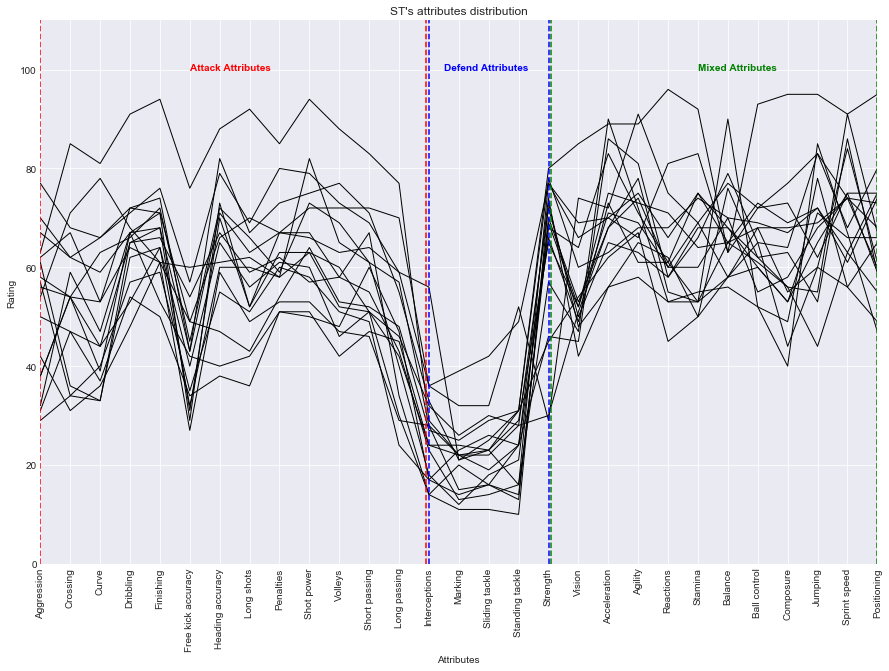

In [10]:
fig, ax = plt.subplots()
df_new_ST = df_new[df_new['Preferred Positions'] == 'ST'].iloc[::200,:-1]
df_new_ST.T.plot.line(color = 'black', figsize = (15,10), legend = False, ylim = (0, 110), title = "ST's attributes distribution", ax=ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(12.9, color='red', linestyle='--')

ax.axvline(13, color='blue', linestyle='--')
ax.axvline(17, color='blue', linestyle='--')

ax.axvline(17.1, color='green', linestyle='--')
ax.axvline(28, color='green', linestyle='--')

ax.text(5, 100, 'Attack Attributes', color = 'red', weight = 'bold')
ax.text(13.5, 100, 'Defend Attributes', color = 'blue', weight = 'bold')
ax.text(22, 100, 'Mixed Attributes', color = 'green', weight = 'bold')

The pattern is quite obvious, but some outliers are found. It is because some of the players are extremely good at their positions and some of them aren't. But I believe most of them should follow the similar pattern if we have normalized them, for the same position. Let's try it out:

Text(22,0.07,'Mixed Attributes')

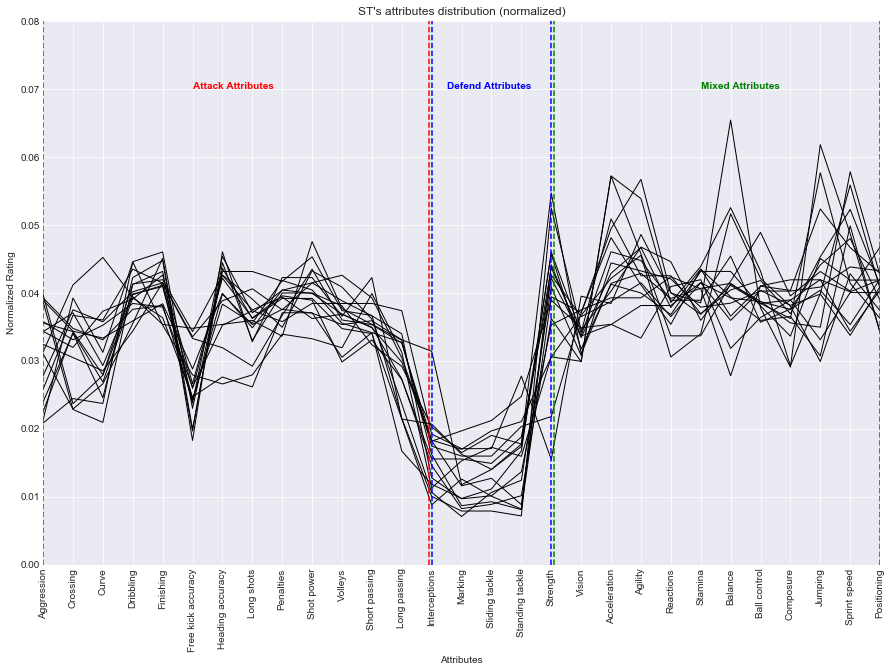

In [11]:
df_new_ST_normalized = df_new_ST.div(df_new_ST.sum(axis=1), axis=0)

fig, ax = plt.subplots()
df_new_ST_normalized.T.plot.line(color = 'black', figsize = (15,10), ylim = (0, 0.08), legend = False, title = "ST's attributes distribution (normalized)", ax=ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Normalized Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(12.9, color='red', linestyle='--')

ax.axvline(13, color='blue', linestyle='--')
ax.axvline(17, color='blue', linestyle='--')

ax.axvline(17.1, color='green', linestyle='--')
ax.axvline(28, color='green', linestyle='--')

ax.text(5, 0.07, 'Attack Attributes', color = 'red', weight = 'bold')
ax.text(13.5, 0.07, 'Defend Attributes', color = 'blue', weight = 'bold')
ax.text(22, 0.07, 'Mixed Attributes', color = 'green', weight = 'bold') 


## Predict binary targets (attack vs defend positions) with logistic regression

The pattern after normalization looks much more obvious. Lets do below:

* Normalize the whole dataset


* Reclassify the target value (preferred positions) to binary groups as below:
- 1 =  attack positions = ST, RW, LW, RM, CM, LM, CAM, CF 
- 0 = defened positions = CDM, CB, LB, RB, RWB, LWB



In [12]:
df_new_normalized = df_new.iloc[:,:-1].div(df_new.iloc[:,:-1].sum(axis=1), axis=0)
mapping = {'ST': 1, 'RW': 1, 'LW': 1, 'RM': 1, 'CM': 1, 'LM': 1, 'CAM': 1, 'CF': 1, 'CDM': 0, 'CB': 0, 'LB': 0, 'RB': 0, 'RWB': 0, 'LWB': 0}
df_new_normalized['Preferred Positions'] = df_new['Preferred Positions']
df_new_normalized = df_new_normalized.replace({'Preferred Positions': mapping})

df_new_normalized.iloc[::1000,]


,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,...,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,0.027815,0.037528,0.035762,0.040177,0.041501,0.033554,0.038852,0.040618,0.037528,0.041501,...,0.039294,0.042384,0.040618,0.027815,0.041060,0.041943,0.041943,0.040177,0.041943,1
1000,0.039282,0.034792,0.033109,0.037598,0.038159,0.024130,0.039843,0.035354,0.037598,0.037037,...,0.038159,0.038159,0.041526,0.039282,0.038721,0.037598,0.040404,0.035354,0.042088,1
2000,0.021291,0.039255,0.031271,0.044578,0.035263,0.027944,0.026613,0.027944,0.033932,0.033267,...,0.053892,0.038589,0.043912,0.052562,0.043247,0.029275,0.039920,0.055888,0.040585,1
3000,0.031065,0.022929,0.026627,0.035503,0.045118,0.019970,0.043639,0.036243,0.039201,0.039201,...,0.042899,0.039201,0.040680,0.041420,0.038462,0.036243,0.057692,0.041420,0.036243,1
4000,0.027009,0.038867,0.025033,0.040184,0.037549,0.023715,0.038208,0.034256,0.037549,0.038867,...,0.046113,0.042819,0.047431,0.045455,0.038208,0.032279,0.035573,0.050725,0.039526,1
5000,0.022193,0.030679,0.037859,0.039164,0.030026,0.035901,0.035901,0.035248,0.041123,0.045692,...,0.048303,0.037859,0.050261,0.040470,0.038512,0.037859,0.033290,0.051567,0.046997,1
6000,0.036757,0.031351,0.030811,0.035676,0.029189,0.031351,0.025946,0.034595,0.037297,0.036757,...,0.036757,0.038919,0.037297,0.039459,0.037838,0.041622,0.039459,0.022703,0.032432,0
7000,0.035219,0.038106,0.032333,0.036374,0.034642,0.020208,0.034065,0.031755,0.037529,0.031755,...,0.035219,0.034642,0.037529,0.033487,0.038684,0.032910,0.038106,0.038106,0.038106,0
8000,0.039876,0.027447,0.024858,0.033143,0.033661,0.023822,0.035733,0.033143,0.025893,0.039876,...,0.026929,0.037286,0.041947,0.029518,0.039358,0.034697,0.038322,0.032108,0.030554,0
9000,0.046556,0.036352,0.017857,0.036990,0.014031,0.026786,0.043367,0.028061,0.039541,0.039541,...,0.024872,0.043367,0.024235,0.027423,0.037628,0.038903,0.036352,0.021046,0.028061,0


Split train test dataset:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_new_normalized.iloc[:,:-1], df_new_normalized.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))


X train shape: (20438, 29)
X test shape: (6813, 29)
y train shape: (20438,)
y test shape: (6813,)


Apply logistic regression to training set:

In [14]:
clf_d = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
acc_d = clf_d.score(X_test, y_test)
print ('Dummy Classifier (most frequent class): {}'.format(acc_d))

clf = LogisticRegression().fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print ('Logistic Regression Accuracy: {}'.format(acc))


Dummy Classifier (most frequent class): 0.6054601497137825
Logistic Regression Accuracy: 0.8586525759577279


## Feature selections

Can we further improve the model accuracy by looking at feature importance?

In [15]:
Coef_list = list(sorted(zip(X_train.columns, abs(clf.coef_[0])),key=lambda x: -x[1]))
Coef_table = pd.DataFrame(np.array(Coef_list).reshape(-1,2), columns = ['Attributes', 'Coef'])

print (Coef_table)

            Attributes            Coef
0              Marking   21.8666019149
1       Sliding tackle   20.6626551324
2      Standing tackle     20.17646476
3        Interceptions   18.8281238958
4            Finishing   15.5909915395
5          Positioning    11.082767834
6              Volleys   10.4558110592
7           Long shots    9.6758577001
8           Aggression   8.92762849465
9               Vision    8.6639298205
10           Dribbling   7.85453855063
11           Penalties   7.50875879166
12            Strength   7.11191516168
13    Heading accuracy   5.92078497997
14          Shot power   5.73893979634
15               Curve    5.6798113312
16             Agility   5.64423999671
17  Free kick accuracy    5.3630163653
18             Jumping   4.88955444074
19        Ball control   4.64390970106
20             Balance   4.43912518301
21        Acceleration   3.63789225036
22             Stamina   2.98797311172
23        Sprint speed   2.67100150534
24       Short passing   

Let's try limit the features to top 10 only:

In [16]:
target_cols = Coef_table[:10]['Attributes'].tolist()

clf_2 = LogisticRegression().fit(X_train[target_cols], y_train)
acc_2 = clf_2.score(X_test[target_cols], y_test)
print ('Logistic Regression Accuracy (10 features): {}'.format(acc_2))

Logistic Regression Accuracy (10 features): 0.8605606927931895


The accuracy is slightly improved. Another interesting observation is **positioning** attribute is quite significant in the model and probably should not be classified under *mix* attributes, while some *attack* attributes like **crossing** is not that significant (probably because LB / RB have high crossing ratings too)

Another interesting observation is that the most significant attributes are mostly defensive ones, meaning that they are most helpful to help us identify the role of a player. In other words, it is extremely rare for a player in an attacking role like ST to be good at those defensive skills, while it is relatively easier for a player in a defensive role to be good at some attacking skills like crossing and free kick accuracy, etc.

## Study PCA impact on model accuracy

Reviewing the whole project again, I would think some of the attributes are quite related to others and therefore I can make use of some dimension reduction technique (namely PCA), I reference this [article](https://www.kaggle.com/arthurtok/principal-component-analysis-with-kmeans-visuals) from [Anisotropic](https://www.kaggle.com/arthurtok) for helping me to implement the model. Let's look at heatmap first:

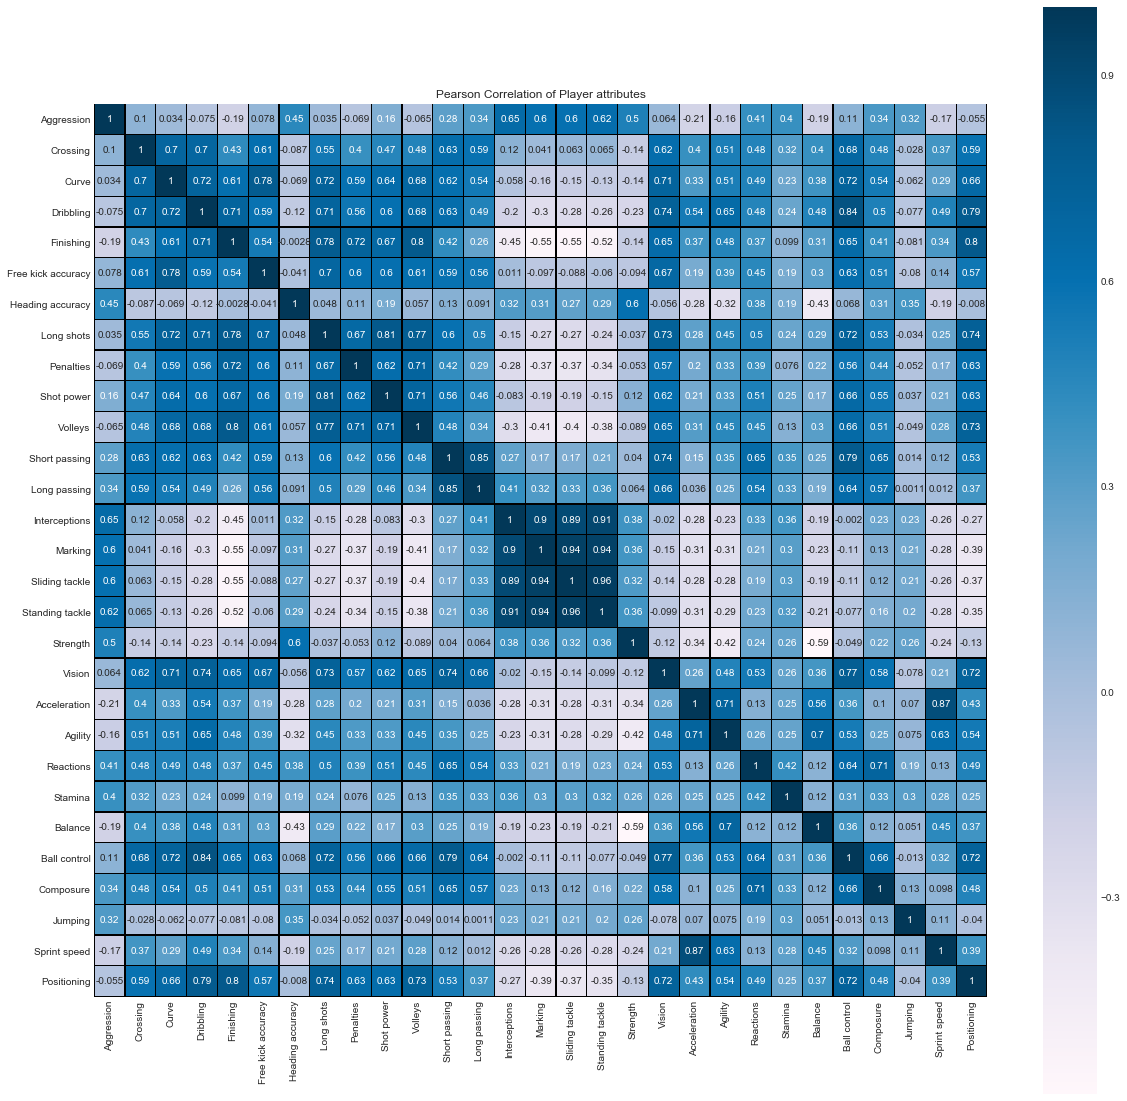

In [17]:
f, ax = plt.subplots(figsize=(20, 20))

plt.title('Pearson Correlation of Player attributes')

sns.heatmap(df_new.corr(),linewidths=0.25,vmax=1.0, square=True, cmap = 'PuBu', linecolor='black', annot=True)

Let's find the reasonable number of component of PCA *(I re-used most codes from above article and only modify to suit my needs)*:

[(0, 39.163536345115865), (1, 65.961848891112425), (2, 73.572591824892427), (3, 78.456921928409059), (4, 80.647314586340528), (5, 82.588915629179041), (6, 84.287435854260437), (7, 85.906940108595634), (8, 87.313494521875555), (9, 88.577512416687313), (10, 89.733990641950697), (11, 90.714600368791878), (12, 91.628773816935563), (13, 92.480203284289246), (14, 93.278893458703223), (15, 94.039896839678264), (16, 94.753454036277077), (17, 95.439133409902269), (18, 96.058885206377767), (19, 96.644975343262274), (20, 97.196233468732757), (21, 97.722804758817247), (22, 98.217923049176889), (23, 98.634071121727985), (24, 99.025779352471446), (25, 99.312139327333057), (26, 99.581521773047641), (27, 99.817262377540203), (28, 100.00000000000006)]


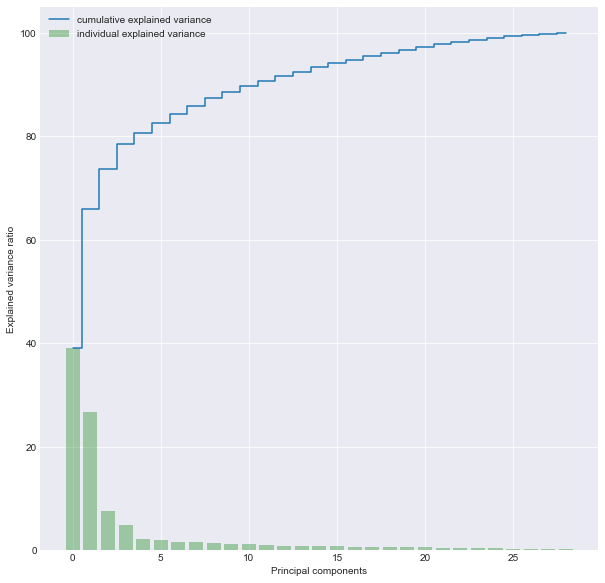

In [18]:
cov_mat = np.cov(df_new.iloc[:,:-1].T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

print(list(zip(range(29),cum_var_exp)))

# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 10))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()



17 components are needed for 95%+ of variance level:

In [19]:
pca = PCA(n_components=17)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_new.iloc[:,:-1], df_new.iloc[:,-1], random_state=0)

X_train_2_pca = pca.fit_transform(X_train_2)
X_train_2_pca = pd.DataFrame(X_train_2_pca)

x_test_2_pca = pca.transform(X_test_2)

clf_17d = LogisticRegression().fit(X_train_2_pca, y_train_2)
acc_17d = clf_17d.score(x_test_2_pca, y_test_2)
print ('Logistic Regression Accuracy with PCA (17 components): {}'.format(acc_17d))


Logistic Regression Accuracy with PCA (17 components): 0.4409217672097461


PCA reduced the performance of our logistic regression model performance. Why is that? I did some research online and found some good explanation [here](https://stackoverflow.com/questions/36668768/why-did-pca-reduced-the-performance-of-logistic-regression)

## Study LDA impact on model accuracy

While PCA ignores class label, LDA takes into consideration of class label to computes the directions (“linear discriminants”) that will represent the axes that that maximize the separation between multiple classes. More detailed explanation can be find [here](http://sebastianraschka.com/Articles/2014_python_lda.html#principal-component-analysis-vs-linear-discriminant-analysis).

Let's see how it is implemented:

In [20]:
lda = LDA(n_components=None)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_new.iloc[:,:-1], df_new.iloc[:,-1], random_state=0)

X_lda = lda.fit(X_train_3, y_train_3)

lda_var_ratios = lda.explained_variance_ratio_

# get number of components needed to explain 95% variance
def select_n_components(var_ratio, goal_var: float) -> int:
    
    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break

    return n_components

print('Number of components needed to explain 95% variance: {}'.format(select_n_components(lda_var_ratios, 0.95)))

Number of components needed to explain 95% variance: 3


In [21]:
lda_n = LDA(n_components=3)
X_train_3_lda = lda_n.fit_transform(X_train_3, y_train_3)
X_train_3_lda = pd.DataFrame(X_train_3_lda)

X_test_3_lda = lda_n.transform(X_test_3)

clf_3d = LogisticRegression().fit(X_train_3_lda, y_train_3)
acc_3d = clf_3d.score(X_test_3_lda, y_test_3)
print ('Logistic Regression Accuracy with LDA (3 components): {}'.format(acc_3d))

Logistic Regression Accuracy with LDA (3 components): 0.4299134008513137


## Predict all positions (14 targets) with logistic regression

Now let's try to predict all positions (14 targets, e.g. ST, LW, etc) with logistic regression. First we need to prepare to data:

In [22]:
df_new_normalized_all = df_new.copy()
mapping_all = {'ST': 0, 'RW': 1, 'LW': 2, 'RM': 3, 'CM': 4, 'LM': 5, 'CAM': 6, 'CF': 7, 'CDM': 8, 'CB': 9, 'LB': 10, 'RB': 11, 'RWB': 12, 'LWB': 13}

df_new_normalized_all = df_new_normalized_all.replace({'Preferred Positions': mapping_all})
df_new_normalized_all.iloc[::1000,]


,Aggression,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,Heading accuracy,Long shots,Penalties,Shot power,...,Agility,Reactions,Stamina,Balance,Ball control,Composure,Jumping,Sprint speed,Positioning,Preferred Positions
0,63,85,81,91,94,76,88,92,85,94,...,89,96,92,63,93,95,95,91,95,0
1000,70,62,59,67,68,43,71,63,67,66,...,68,68,74,70,69,67,72,63,75,0
2000,32,59,47,67,53,42,40,42,51,50,...,81,58,66,79,65,44,60,84,61,0
3000,42,31,36,48,61,27,59,49,53,53,...,58,53,55,56,52,49,78,56,49,0
4000,41,59,38,61,57,36,58,52,57,59,...,70,65,72,69,58,49,54,77,60,1
5000,34,47,58,60,46,55,55,54,63,70,...,74,58,77,62,59,58,51,79,72,2
6000,68,58,57,66,54,58,48,64,69,68,...,68,72,69,73,70,77,73,42,60,8
7000,61,66,56,63,60,35,59,55,65,55,...,61,60,65,58,67,57,66,66,66,8
8000,77,53,48,64,65,46,69,64,50,77,...,52,72,81,57,76,67,74,62,59,9
9000,73,57,28,58,22,42,68,44,62,62,...,39,68,38,43,59,61,57,33,44,9


Fit the model:

In [23]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_new_normalized_all.iloc[:,:-1], df_new_normalized_all.iloc[:,-1], random_state=0)

print('X train shape: {}'.format(X_train_all.shape))
print('X test shape: {}'.format(X_test_all.shape))
print('y train shape: {}'.format(y_train_all.shape))
print('y test shape: {}'.format(y_test_all.shape))

X train shape: (20438, 29)
X test shape: (6813, 29)
y train shape: (20438,)
y test shape: (6813,)


In [24]:
clf_d_all = DummyClassifier(strategy = 'most_frequent').fit(X_train_all, y_train_all)
acc_d_all = clf_d_all.score(X_test_all, y_test_all)
print ('Dummy Classifier (most frequent class): {}'.format(acc_d_all))

clf_all = LogisticRegression().fit(X_train_all, y_train_all)
acc_all = clf_all.score(X_test_all, y_test_all)
print ('Logistic Regression Accuracy: {}'.format(acc_all))

Dummy Classifier (most frequent class): 0.1271099368853662
Logistic Regression Accuracy: 0.44136210186408337


## Predict all positions (14 targets) with random forest

The accuracy significantly drops when we tried to classify 14 targets instead of 2. Let's try out other model, Random forest:

In [25]:
clf_all_for = RandomForestClassifier(random_state=0).fit(X_train_all, y_train_all)
acc_all_for = clf_all_for.score(X_test_all, y_test_all)
print ('Random Forest Accuracy (Default parameters): {}'.format(acc_all_for))


Random Forest Accuracy (Default parameters): 0.24482606781153676


Accuracy isn't satisfying, let's try use gridsearchcv to find better parameters to the model:

In [26]:
parameters_f = [{'max_depth': range(2,10), 'n_estimators': range(2,8,2), 'max_features': range(10,20)}]
clf_all_for_g = GridSearchCV(RandomForestClassifier(random_state=0), parameters_f)
clf_all_for_g.fit(X_train_all, y_train_all)

print('Best score for train data:', clf_all_for_g.best_score_)
print('Best depth:',clf_all_for_g.best_estimator_.max_depth)
print('Best n trees:',clf_all_for_g.best_estimator_.n_estimators)
print('Best n features:',clf_all_for_g.best_estimator_.max_features)
print('Score for test data:',clf_all_for_g.score(X_test_all, y_test_all))



Best score for train data: 0.417017320677
Best depth: 7
Best n trees: 6
Best n features: 11
Score for test data: 0.408924115661


## Predict all positions (14 targets) with neural networks

Let's look at neural networks and parameters:

In [27]:
clf_all_nn = MLPClassifier(random_state=0).fit(X_train_all, y_train_all)
acc_all_nn = clf_all_nn.score(X_test_all, y_test_all)
print ('Neural Networks Accuracy (Default parameters): {}'.format(acc_all_nn))

parameters_n = [{'alpha': [0.0001, 0.001, 0.01, 0.1], 'hidden_layer_sizes':[(10,),(20,),(100,)]}]
clf_all_nn_g = GridSearchCV(MLPClassifier(random_state=0), parameters_n)
clf_all_nn_g.fit(X_train_all, y_train_all)

print('Best score for train data:', clf_all_nn_g.best_score_)
print('Best alpha:',clf_all_nn_g.best_estimator_.alpha)
print('Best hidden_layer_sizes:',clf_all_nn_g.best_estimator_.hidden_layer_sizes)
print('Score for test data:',clf_all_nn_g.score(X_test_all, y_test_all))


Neural Networks Accuracy (Default parameters): 0.4077498899163364
Best score for train data: 0.437762990508
Best alpha: 0.001
Best hidden_layer_sizes: (20,)
Score for test data: 0.430353735506


Accuracy improves but is not very high. This may be due to the fact that many players have mixed attributes, like ST / LW / RW may process very similar pattern in attributes. We might need more other signficant features in this case.

Hope it is a good read, welcome any discussion :)

In [41]:
for i in range(100,200,5):
    clf_knn = KNeighborsClassifier(n_neighbors=i) 
    clf_knn.fit(X_train_all, y_train_all) 
    print('i=',i)
    print(clf_knn.score(X_test_all, y_test_all))


i= 100
0.424189050345
i= 105
0.420813151328
i= 110
0.422868046382
i= 115
0.422721268164
i= 120
0.421840598855
i= 125
0.422427711728
i= 130
0.423455159254
i= 135
0.424189050345
i= 140
0.424482606781
i= 145
0.426831058271
i= 150
0.422868046382
i= 155
0.421106707765
i= 160
0.420372816674
i= 165
0.421693820637
i= 170
0.423455159254
i= 175
0.426243945399
i= 180
0.426537501835
i= 185
0.424776163217
i= 190
0.424042272127
i= 195
0.425950388962
